#### Ivanna Nguyen, Shaylan Patel, Saba Rauf, Johnny Silimanotham
## Purpose: Choosing the best model that perfroms the best at catching customers churning (1).
### Dataset: Kaggle "Bank Customer Churn Dataset" https://www.kaggle.com/datasets/bhuviranga/customer-churn-data

In [89]:
# importing all necessary packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [90]:
# read in data
bccp = pd.read_csv('Bank Customer Churn Prediction.csv')
bccp.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [91]:
# Check the dimensions of the dataset (rows, columns)
bccp.shape

(10000, 12)

In [92]:
# Get statistical summary of numerical columns
# Shows count, mean, std, min, quartiles, and max values
bccp.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [93]:
# checking for null values
bccp.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [94]:
# datatypes
bccp.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [95]:
# Remove customer_id column as it's just an identifier
# Not useful for prediction
bccp = bccp.drop(columns=['customer_id'])

In [96]:
# making sure column 'customer_id' was removed
bccp.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

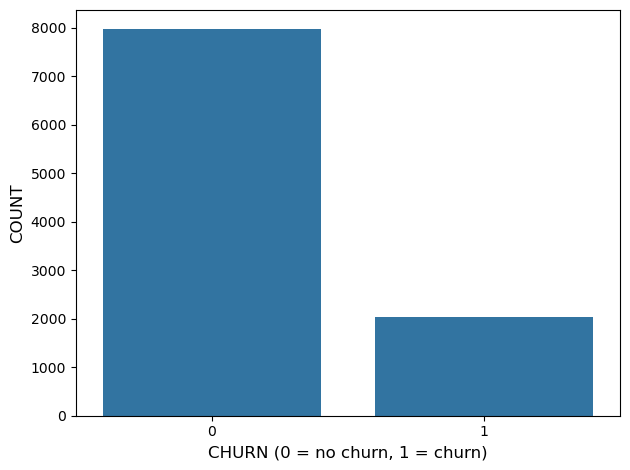

In [97]:
# checking countplot we can see that the data is imbalanced
p = sns.countplot(data=bccp, x = 'churn', order = [0,1])
p.set_xlabel('CHURN (0 = no churn, 1 = churn)', fontsize = 12)
p.set_ylabel('COUNT', fontsize = 12)
plt.tight_layout()
plt.show()

### Preprocessing and cleaning

In [ ]:
# Define the features (X) and the target (y)
X = bccp.drop(columns=['churn'])
y = bccp['churn']

# Encode categorical features
X = pd.get_dummies(X, columns=['country', 'gender'], drop_first=True)

#scale data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# pipeline
estimator = SVC(kernel = 'linear')
rfe = RFE(estimator = estimator, n_features_to_select = 10, step = 1)
pipe_rfe = Pipeline(steps=[('scaler', scaler), ('rfe', rfe)])
pipe_rfe.fit(X, np.ravel(y))

selected_features = X.columns[pipe_rfe['rfe'].support_]
print(f'Selected ({len(selected_features)}):')
print(list(selected_features))

In [99]:
# Train test split (70% training, 30% testing)
X_sel = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, random_state = 19, shuffle=True, stratify=y)
X_train.shape, X_test.shape

((7000, 10), (3000, 10))

### GaussianNB

In [100]:
# Import Gaussian Naive Bayes classifier and accuracy metric
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [101]:
# Initialize Gaussian Naive Bayes mode
NBModel = GaussianNB()

In [102]:
# Train the Naive Bayes model on scaled training data
NBModel.fit(X_train_std, y_train)

GaussianNB()

In [103]:
# Make predictions on test set
y_pred = NBModel.predict(X_test_std)
cm = confusion_matrix(y_test, y_pred)
# Calculate accuracy score
score = accuracy_score(y_test, y_pred)

In [104]:
# Display test accuracy
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Test Accuracy: 0.8210


In [105]:
print('TEST SCORES: GAUSSIAN NAIVE BAYES')
print('Test Accuracy:', score)

print('\nTest Classification Report:')
print(classification_report(y_test, y_pred))

print('\nTest Confusion Matrix:')
print(cm)

TEST SCORES: GAUSSIAN NAIVE BAYES
Test Accuracy: 0.821

Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2389
           1       0.61      0.34      0.44       611

    accuracy                           0.82      3000
   macro avg       0.73      0.64      0.67      3000
weighted avg       0.80      0.82      0.80      3000


Test Confusion Matrix:
[[2255  134]
 [ 403  208]]


## Report Interpretation

Class 0 - 2389 non-customers in the test set

Precision(0.85): The model predicts a customer will not churn, It's correct 85% of the time.

Recall:(0.94): Customer who did not churn, the model correctly predicted 94% of them.


Class 1 - 611 churn customers 

Precision(0.73): The Model predicts the customer will churn, and it is correct 73% of the time.

Recall(0.34): Out of all customers who churned, the model only identifies 34%. The model is missing 66% of the customers who are leaving. Critical weakness!!!


In [126]:
# Evaluate training set performance to check for overfitting
y_train_pred = NBModel.predict(X_train_std)
train_accuracy = accuracy_score(y_train, y_train_pred)
cm_train = confusion_matrix(y_train, y_train_pred)

In [107]:
print(f"Training Accuracy: {train_accuracy:.4f}")

print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTraining Confusion Matrix:")
print(cm_train)

Training Accuracy: 0.8246

Training Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      5574
           1       0.62      0.36      0.45      1426

    accuracy                           0.82      7000
   macro avg       0.74      0.65      0.67      7000
weighted avg       0.80      0.82      0.81      7000


Training Confusion Matrix:
[[5263  311]
 [ 917  509]]


No Overfitting

Training accuracy 82%, similar to the test model

### LogisticRegression

In [130]:
#Training the model and setting class_weight to 'balanced' to account for imbalance
model = LogisticRegression(random_state = 19, max_iter = 500, class_weight = 'balanced')
model.fit(X_train_std, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=19)

In [131]:
#Predicting
y_pred_model = model.predict(X_test_std)

In [129]:
#Accuracy scores
print("Logistic Regression Accuracy of balanced data:", accuracy_score(y_test, y_pred_model))

Logistic Regression Accuracy of balanced data: 0.7153333333333334


In [132]:
# Model correctly predcits  71.5% of the time when class weights are balanced

In [133]:
print(classification_report(y_test, y_pred_model))

              precision    recall  f1-score   support

           0       0.90      0.73      0.80      2389
           1       0.39      0.68      0.49       611

    accuracy                           0.72      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.72      0.74      3000



In [113]:
#Class 0 : Precision of 'not churn' correcly identifies 90% of the time
#Class 1: Precision of  'churn" correctly identifies 39% of the time

In [114]:
#Model is good at finding which customers will stay but misses many churn customers. Not detecting churn well.
#Imabalned class 0 > class 1

In [134]:
cm = confusion_matrix(y_test, y_pred_model)
print("Confusion Matrix:\n")
print(cm)


Confusion Matrix:

[[1733  656]
 [ 198  413]]


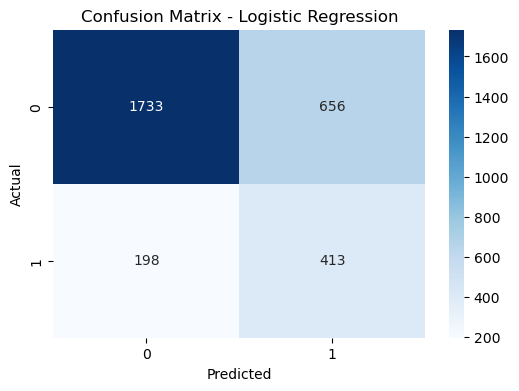

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [136]:
#Model correctly predicts 1733 non churn customers
#Incorrectly predicts TR 198 as churn
#Misses BL churn cases
#Correctly captured BR actual churns

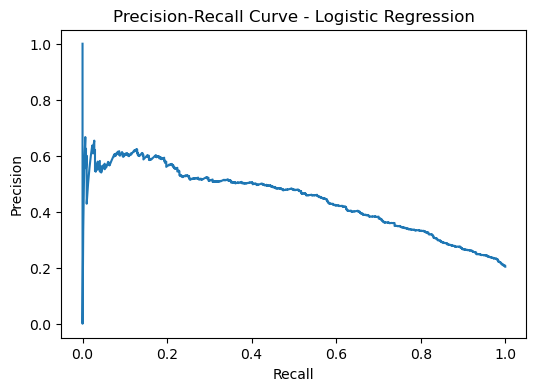

In [137]:

from sklearn.metrics import precision_recall_curve

y_prob_model = model.predict_proba(X_test_std)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_test, y_prob_model)

plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()


#### Curve slopes downwards indicating LR struggles to identidy churn from non churn
#### High precision at low recal, as we try to capture more churn cases, model is making more mistakes
#### P drops, R increases


### K Nearest Neighbors

In [138]:
# Try different k values looping through k= 1 to 20
k_values = range(1, 21)
test_accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_std, y_train)
    y_test_pred_temp = knn_temp.predict(X_test_std)
    test_accuracies.append(accuracy_score(y_test, y_test_pred_temp))

# Choosing the best k value with the highest accuracy 
best_k = k_values[np.argmax(test_accuracies)]
print(f"Best k based on test accuracy: {best_k}")
print(f"Best test accuracy: {max(test_accuracies):.4f}")

# Train the final knn model
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_std, y_train)

# Predict churn for the test set 
y_pred = knn.predict(X_test_std)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Classification report for knn showing precision, recall, F1 score for both classes
print("\nKNN Test Accuracy:", acc)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Churn", "Churn"]))


Best k based on test accuracy: 15
Best test accuracy: 0.8417

KNN Test Accuracy: 0.8416666666666667

Confusion Matrix:
[[2322   67]
 [ 408  203]]

Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.85      0.97      0.91      2389
       Churn       0.75      0.33      0.46       611

    accuracy                           0.84      3000
   macro avg       0.80      0.65      0.68      3000
weighted avg       0.83      0.84      0.82      3000



#### KNN correctly predicts about 84.1% of customers overall.
#### For NOT churn (class 0), the model performs very well: 2322 correctly predicted and only 67 incorrectly predicted as churn.
#### For churn (class 1), the model struggles more: it correctly identifies 203 churners but misses 408 of them.
#### This means KNN is strong at detecting customers who will stay, but it misses many customers who are actually likely to leave.

### Random Forest

In [120]:
# instantiate and fit Random Forest Classifier model
# balancing class weight because of unbalanced data set
rfc = RandomForestClassifier(n_estimators = 100, random_state = 19, class_weight = "balanced")
rfc.fit(X_train_std, y_train)

RandomForestClassifier(class_weight='balanced', random_state=19)

In [121]:
# training scores of Random Forest Classifer
y_train_pred = rfc.predict(X_train_std)
print("Training Classification Report for RFC: ")
print(classification_report(y_train, y_train_pred))

Training Classification Report for RFC: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5574
           1       1.00      1.00      1.00      1426

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000



In [122]:
# test scores of Random Forest Classifier
y_test_pred = rfc.predict(X_test_std)
print("Test Classification Report for RFC: ")
print(classification_report(y_test, y_test_pred))

Test Classification Report for RFC: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.78      0.43      0.55       611

    accuracy                           0.86      3000
   macro avg       0.83      0.70      0.73      3000
weighted avg       0.85      0.86      0.84      3000



#### Adding complexity

In [123]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 19, max_depth = 10, min_samples_split = 8, class_weight = 'balanced')
rfc.fit(X_train_std, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=8, random_state=19)

In [124]:
y_train_pred = rfc.predict(X_train_std)
print("Training Classification Report for RFC: ")
print(classification_report(y_train, y_train_pred))

Training Classification Report for RFC: 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5574
           1       0.72      0.83      0.77      1426

    accuracy                           0.90      7000
   macro avg       0.84      0.88      0.86      7000
weighted avg       0.91      0.90      0.90      7000



In [125]:
y_test_pred = rfc.predict(X_test_std)
print("Test Classification Report for RFC: ")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

Test Classification Report for RFC: 
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2389
           1       0.61      0.64      0.63       611

    accuracy                           0.84      3000
   macro avg       0.76      0.77      0.76      3000
weighted avg       0.85      0.84      0.85      3000

[[2140  249]
 [ 219  392]]


# Key Findings
## Accuracy may not be the best predictor when we want to see the best at catching customer churn
### Precision is a better metric 

### Naive Bayes: Precision of Churn(1) = 61% | Model Accuracy = 82%
### LogiticRegression: Precision of Churn(1) | 39%. Model Accuracy = 72%
### KNN: Precision of Churn(1) = 75%. Model Accuracy | 84%
### RandomForest: Precision of Churn(1) = 61%. Model Accuracy | 84%

# Best Model

### When we base the best performance on precision or how well a model is able to correctly identify a customer that churns, KNN is the best model. It has the same accuracy of RandomForestClassifier but a better precision score.